In [1]:
# just imports
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec

from scipy.ndimage.interpolation import rotate
from sklearn.model_selection import train_test_split

In [2]:
# local imports
sys.path.append('../')
from VAE.rg_dataset import LRG, BasicDataset
from VAE.loss_funcs import VAE_Loss
from VAE import vae_models

In [3]:
%%time
data_path = '../data/'
aug=5

lrg_data_set   = LRG(use_kittler=True, n_aug=aug, blur=True, catalog_dir=data_path + 'catalog/mrt-table3.txt', 
                                                               file_dir=data_path + 'lrg')

unlrg_data_set = LRG(use_kittler=True, n_aug=aug, blur=True, catalog_dir=data_path + 'catalog/mrt-table4.txt',
                                                               file_dir=data_path + 'unlrg')

../data/lrg:	1442/1442
../data/unlrg:	14245/14245
CPU times: user 6min 23s, sys: 6min 56s, total: 13min 19s
Wall time: 4min 28s


In [19]:
batch_size = 16 #supposedly low batch size helps fater convergence

data_loader_lrg   = data.DataLoader(lrg_data_set,   batch_size=128, shuffle=False)
data_loader_unlrg = data.DataLoader(unlrg_data_set, batch_size=16,  shuffle=False)

sample = iter(data_loader_unlrg).next()

In [5]:
class VAE(nn.Module):
    def __init__(self, lt_dim=4, k=None, batch_norm=True):
        super(VAE, self).__init__()
        self.k = k
        n_layers = len(self.k)
        encoder_layers = []
        decoder_layers = []
        
        for i in range( n_layers -1) :
            in_c, out_c = self.k[i], self.k[i + 1]
            if(in_c == 'M'): continue
            stride = 1
            if out_c == 'M':
                stride = 2
                i += 1
                out_c = self.k[i + 1]
            layer = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride)
            encoder_layers.append(layer)
            if batch_norm:
                encoder_layers.append(nn.BatchNorm2d(out_c))
            encoder_layers.append(nn.ReLU(inplace=True))
        self.encoder = nn.Sequential(*encoder_layers)
        
        for i in range(n_layers - 1, 0, -1):
            in_c, out_c = self.k[i], self.k[i - 1]
            if(in_c == 'M'): continue
            stride = 1
            output_padding=0
            if out_c == 'M':
                stride = 2
                i -= 1
                out_c = self.k[i - 1]
                output_padding=1
                
            layer = nn.ConvTranspose2d(in_c, out_c, kernel_size=3, padding=1, 
                                       output_padding=output_padding, stride=stride)
            decoder_layers.append(layer)
            if batch_norm:
                decoder_layers.append(nn.BatchNorm2d(out_c))
            decoder_layers.append(nn.ReLU(inplace=True))

        self.decoder = nn.Sequential(*decoder_layers[:-1])
        
        self.fc_mu = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        self.fc_ep = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        
        self.fc_dc = nn.Linear(lt_dim, self.k[-1]*2*2)
        
    def encode(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(-1, self.k[-1]*2*2)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        if self.training :
            return mu + eps*std
        return mu

    def decode(self, x):
        x = F.relu(self.fc_dc(x))
        x = x.view(-1, self.k[-1], 2, 2) #reshape
        return torch.sigmoid(self.decoder(x))
    
    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        return d, mu, var

In [21]:
def compact_extended_loss(target, output, device):
    #########    Compact vs Extended    #########
    extended = target > 1
    extended = Variable(extended.float().to(device), requires_grad=False)
    pred_ext = torch.sigmoid(output)
    ext_loss = F.binary_cross_entropy(pred_ext, extended, reduction='sum').div(len(pred_ext))

    return ext_loss

def fri_frii_loss(target, output, device):
    o = torch.sigmoid(output)[target > 1]
    c = target[target > 1]

    o = o[c < 4] # FRI == 2, FRII == 3
    c = c[c < 4]

    c = Variable( (c == 3).float().to(device), requires_grad=False)
    fr_loss = F.binary_cross_entropy(o, c, reduction='sum').div(len(c))

    return fr_loss

def train_step_vae(mode, device, data_loader, optim, epoch, loss_fun, log_interval=5, beta=1):
    model.train()
    s = ''
    r_loss = 0
    batch_sum = 0
    avg_r_loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        batch_sum += len(data)
        data = data.to(device)
        target = Variable(target, requires_grad=False).to(device)
        #Forward Pass
        optim.zero_grad()
        output = model(data)
        
        #############################################
        ######### check against known class #########
        #############################################
        #########    Compact vs Extended    #########
        ext_loss = compact_extended_loss(target, output[1][:,0], device)
        # # #########       FRI vs FRII         #########
        fr_loss = fri_frii_loss(target, output[1][:, 1], device)

        # BCE Loss
        r_loss, g_loss = loss_fun(output, data)
        loss = r_loss + (beta * g_loss) + 20 * (ext_loss + fr_loss)#
        avg_r_loss += r_loss.item()
        #Backpropagation
        loss.backward()
        optim.step()
        s = 'Train Epoch: {:3d} [{:5d}/{:5d} ({:3.0f}%)]\tLoss: {:4.4f}\tR_Loss: {:4.4f}\tDKL: {:4.4f}'
        s = s.format(epoch, batch_sum, len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()/len(data),
                     r_loss.item()/len(data), g_loss.item()/len(data))
        
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s, avg_r_loss / batch_sum

In [22]:
def test_step_vae(model, device, data_loader, loss_fun, learn_rot=False):
    model.eval()
    avg_r_loss = 0
    batch_sum = 0 
    for batch_idx, (data, target) in enumerate(data_loader):
        batch_sum += len(data)
        with torch.no_grad():
            data = data.to(device)
            #Forward Pass
            output = model(data)
            # BCE Loss
            r_loss , g_loss = loss_fun(output, data)
            avg_r_loss += r_loss.item()
            
    return avg_r_loss / batch_sum

In [23]:
device = 'cuda'
epochs = 40

In [24]:
model(sample[0].to(device))[1][:,0].shape

torch.Size([16])

Train Epoch:   1 [69900/69900 (100%)]	Loss: 59.2573	R_Loss: 57.8382	DKL: 0.1642	AvgR 91.6196	Test Loss : 5.5301   Time : 145.38s
Train Epoch:   2 [69900/69900 (100%)]	Loss: 24.6337	R_Loss: 23.3649	DKL: 0.3754	AvgR 23.9138	Test Loss : 3.0745   Time : 140.46s
Train Epoch:   3 [69900/69900 (100%)]	Loss: 15.0415	R_Loss: 14.0030	DKL: 0.2536	AvgR 8.8706	Test Loss : 1.2225   Time : 142.51s
Train Epoch:   4 [69900/69900 (100%)]	Loss: 12.5996	R_Loss: 11.3689	DKL: 0.3027	AvgR 5.0381	Test Loss : 0.9670   Time : 145.29s
Train Epoch:   5 [69900/69900 (100%)]	Loss: 12.6004	R_Loss: 11.2866	DKL: 0.6049	AvgR 3.9361	Test Loss : 0.8019   Time : 145.52s
Train Epoch:   6 [69900/69900 (100%)]	Loss: 11.9480	R_Loss: 10.7155	DKL: 0.6003	AvgR 3.6770	Test Loss : 0.7640   Time : 144.14s
Train Epoch:   7 [69900/69900 (100%)]	Loss: 11.1937	R_Loss: 9.4766	DKL: 0.6455	AvgR 3.4772	Test Loss : 0.7274   Time : 138.33s
Train Epoch:   8 [69900/69900 (100%)]	Loss: 12.4156	R_Loss: 10.9453	DKL: 0.6685	AvgR 3.4019	Test Loss :

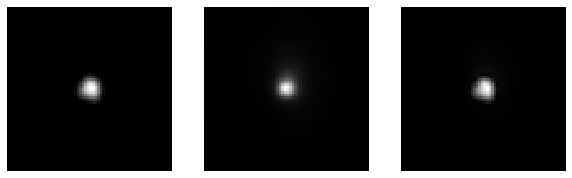

Train Epoch:  11 [69900/69900 (100%)]	Loss: 10.0416	R_Loss: 8.7201	DKL: 0.6547	AvgR 3.1658	Test Loss : 0.6985   Time : 136.96s
Train Epoch:  12 [69900/69900 (100%)]	Loss: 10.6891	R_Loss: 9.3014	DKL: 0.7456	AvgR 3.1336	Test Loss : 0.6877   Time : 140.10s
Train Epoch:  13 [69900/69900 (100%)]	Loss: 9.6911	R_Loss: 8.3621	DKL: 0.7505	AvgR 3.0988	Test Loss : 0.6783   Time : 141.10s
Train Epoch:  14 [69900/69900 (100%)]	Loss: 9.8403	R_Loss: 8.4628	DKL: 0.7649	AvgR 3.0810	Test Loss : 0.7669   Time : 141.57s
Train Epoch:  15 [69900/69900 (100%)]	Loss: 9.8969	R_Loss: 8.5060	DKL: 0.7674	AvgR 3.0673	Test Loss : 0.6686   Time : 139.62s
Train Epoch:  16 [69900/69900 (100%)]	Loss: 10.1533	R_Loss: 8.6935	DKL: 0.8374	AvgR 3.0599	Test Loss : 0.6746   Time : 147.26s
Train Epoch:  17 [69900/69900 (100%)]	Loss: 9.4119	R_Loss: 7.9360	DKL: 0.7637	AvgR 3.0504	Test Loss : 0.6881   Time : 138.63s
Train Epoch:  18 [69900/69900 (100%)]	Loss: 10.1347	R_Loss: 8.6341	DKL: 0.7423	AvgR 3.0462	Test Loss : 0.6662   Tim

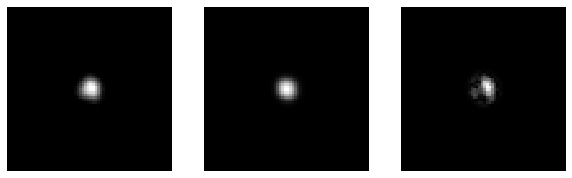

Train Epoch:  21 [69900/69900 (100%)]	Loss: 9.7646	R_Loss: 8.2134	DKL: 0.8106	AvgR 3.0292	Test Loss : 0.6650   Time : 132.66s
Train Epoch:  22 [69900/69900 (100%)]	Loss: 10.0974	R_Loss: 8.5457	DKL: 0.8258	AvgR 3.0276	Test Loss : 0.6644   Time : 133.07s
Train Epoch:  23 [69900/69900 (100%)]	Loss: 11.1301	R_Loss: 9.5269	DKL: 0.8545	AvgR 3.0247	Test Loss : 0.6624   Time : 135.31s
Train Epoch:  24 [69900/69900 (100%)]	Loss: 9.8750	R_Loss: 8.5452	DKL: 0.7752	AvgR 3.0206	Test Loss : 0.6628   Time : 133.49s
Train Epoch:  25 [69900/69900 (100%)]	Loss: 9.2343	R_Loss: 7.7447	DKL: 0.7759	AvgR 3.0193	Test Loss : 0.6670   Time : 132.19s
Train Epoch:  26 [69900/69900 (100%)]	Loss: 10.1482	R_Loss: 8.6033	DKL: 0.9162	AvgR 3.0184	Test Loss : 0.6595   Time : 132.34s
Train Epoch:  27 [69900/69900 (100%)]	Loss: 10.0957	R_Loss: 8.4106	DKL: 0.7909	AvgR 3.0167	Test Loss : 0.6685   Time : 131.56s
Train Epoch:  28 [69900/69900 (100%)]	Loss: 10.7993	R_Loss: 9.2155	DKL: 0.8526	AvgR 3.0124	Test Loss : 0.6677   Ti

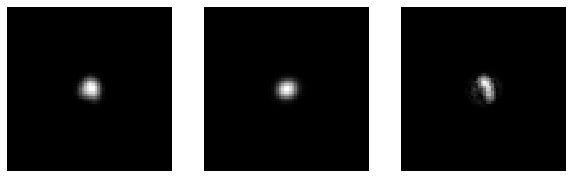

Train Epoch:  31 [69900/69900 (100%)]	Loss: 10.3405	R_Loss: 8.9031	DKL: 0.8313	AvgR 3.0070	Test Loss : 0.6592   Time : 131.79s
Train Epoch:  32 [69900/69900 (100%)]	Loss: 9.7200	R_Loss: 8.2052	DKL: 0.7781	AvgR 3.0062	Test Loss : 0.6593   Time : 135.92s
Train Epoch:  33 [69900/69900 (100%)]	Loss: 9.2550	R_Loss: 7.8409	DKL: 0.8118	AvgR 3.0028	Test Loss : 0.6633   Time : 132.20s
Train Epoch:  34 [69900/69900 (100%)]	Loss: 8.9695	R_Loss: 7.5409	DKL: 0.8457	AvgR 3.0062	Test Loss : 0.6571   Time : 132.07s
Train Epoch:  35 [69900/69900 (100%)]	Loss: 10.0708	R_Loss: 8.5362	DKL: 0.8744	AvgR 3.0009	Test Loss : 0.6574   Time : 131.95s
Train Epoch:  36 [69900/69900 (100%)]	Loss: 9.2743	R_Loss: 7.8171	DKL: 0.8449	AvgR 3.0015	Test Loss : 0.6606   Time : 130.20s
Train Epoch:  37 [69900/69900 (100%)]	Loss: 9.8334	R_Loss: 8.2997	DKL: 0.8232	AvgR 2.9996	Test Loss : 0.6672   Time : 132.00s
Train Epoch:  38 [69900/69900 (100%)]	Loss: 9.3410	R_Loss: 7.8482	DKL: 0.8657	AvgR 3.0012	Test Loss : 0.6579   Time 

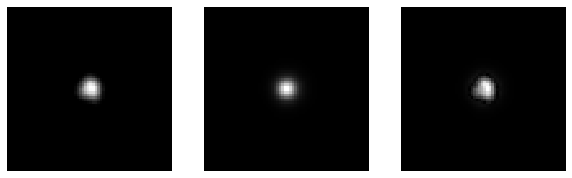

In [25]:
k = [1, 16, 'M', 32, 'M', 64, 64,'M', 64, 'M', 128, 128, 'M', 256]
model = VAE(lt_dim=8, k=k).to(device)
# model = vae_models.VAE().to(device)
optimizer = Adam(model.parameters(), lr=0.0005, weight_decay=1E-5)
loss_fun = VAE_Loss()

train_loss = []
test_loss  = []
for epoch in range(1, epochs+1):
    #LRG, forced params
    start = time.time()
    s, l = train_step_vae(model, device, data_loader_unlrg, optimizer, epoch, loss_fun=loss_fun)
    loss = test_step_vae(model, device, data_loader_lrg, loss_fun=loss_fun)
    
    train_loss.append(l)
    test_loss.append(loss)
    t = time.time() - start
    
    sys.stdout.write('{}\tAvgR {:.4f}\tTest Loss : {:4.4f}   Time : {:.2f}s\n'.format(s, l, loss, t))
    if epoch % 10 == 0: 
        f, ax = plt.subplots(1, 3, figsize=(10, 5))
        o = model(sample[0].to(device))
        ax[0].imshow(sample[0][1][0], cmap='gray')
        ax[1].imshow(o[0][1][0].detach().cpu(), cmap='gray')
        diff = sample[0][1][0] - o[0][1][0].detach().cpu()
        ax[2].imshow(np.abs(diff), cmap='gray')
        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')
        plt.show()

In [ ]:
i = 1
plt.imshow(sample[0][i][0])

In [ ]:
o = model(sample[0].to(device))

In [ ]:
# o.shape

In [ ]:
plt.imshow(o[0][i][0].detach().cpu())

In [ ]:
torch.save(model, 'SimpleVAE')

In [ ]:
s = sample[0][i:i+1]

In [ ]:
with torch.no_grad():
    e = model.encode(s.to(device))[0]

In [ ]:
with torch.no_grad():
    d = model.decode(e)

In [ ]:
plt.imshow(d[0][0].cpu())

In [ ]:
f, ax = plt.subplots(1, 9, figsize=(40, 20))

j = 7
for k, i in enumerate(np.arange(-2, 2.5, .5)):
    b = torch.tensor(e)
    b[0][j] = e[0][j] + 2*i
    with torch.no_grad():
        d = model.decode(b).cpu()[0][0]
    ax[k].imshow(d, cmap='gray')
    ax[k].axis('off')

In [127]:
e[0][6]

tensor(-0.0478, device='cuda:0')

In [80]:
b = torch.tensor(e)

In [83]:
b[0][0] = 0

In [115]:
np.arange(-4, 4.5, 1)

array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])